# DATA PREPROCESSING:

## IMPORT ALL LIBRARIES:

In [112]:
import numpy as np
import pandas as pd 
import os
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add

Listing of all train and test images:

In [113]:
train_list=os.listdir('../input/cityscapes-image-pairs/cityscapes_data/train')
test_list=os.listdir('../input/cityscapes-image-pairs/cityscapes_data/val')

In [114]:
train_list=['../input/cityscapes-image-pairs/cityscapes_data/train/'+i for i in train_list]
test_list=['../input/cityscapes-image-pairs/cityscapes_data/val/'+i for i in test_list]

In [115]:
train_list[:10]

['../input/cityscapes-image-pairs/cityscapes_data/train/919.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1357.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/795.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/84.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2520.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/33.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1505.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/698.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/1548.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/train/2439.jpg']

## Load image:

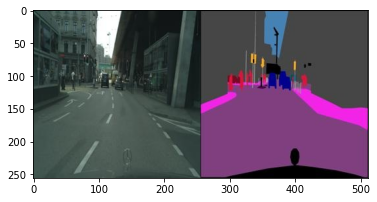

In [116]:
img=cv2.imread(train_list[13])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
plt.imshow(img)

In [117]:
def load_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X=img[:,:256,:]
    Y=img[:,256:,:]
    return X,Y

## ASSIGN CLASS LABELS USING KMEANS FOR SEGMENTED IMAGES:

In [123]:
from tqdm import tqdm
colors=[]

for i in tqdm(range(200)):
    x,y=load_image(train_list[i])
    colors.append(y.reshape(y.shape[0]*y.shape[1],3))

100%|██████████| 200/200 [00:00<00:00, 315.44it/s]


In [124]:
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))
print(colors.shape)

(13107200, 3)


In [125]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(colors)

KMeans(n_clusters=13, random_state=0)

In [126]:
kmeans.cluster_centers_

array([[107.06664474, 139.48210362,  37.22859047],
       [127.97974731,  63.08596687, 127.30394832],
       [  4.38744495,   3.04712925,   7.06144067],
       [ 69.95505555,  70.35112951,  68.74029802],
       [236.22385628,  40.16583347, 224.62143959],
       [  3.72276039,   3.54159047, 135.31777029],
       [209.75947506, 156.67567757, 159.81385164],
       [130.88892182, 124.39677477, 104.74041362],
       [199.02688748,  27.78077482,  61.88352506],
       [ 76.43878515, 126.76333799, 172.41443934],
       [159.323443  , 244.5645187 , 156.3561928 ],
       [215.14773058, 200.5995931 ,  40.75965171],
       [ 82.26665601,   6.74513132,  68.68993585]])

In [127]:
def mask_to_labels(mask):
    masked=mask.reshape((mask.shape[0]*mask.shape[1],3))
    pred=kmeans.predict(masked)
    pred=pred.reshape(mask.shape[0],mask.shape[1])

    cls = np.zeros((mask.shape[0], mask.shape[1], 13))
    
    for i in range(13):
        cls[:, :, i] = (pred == i ).astype(int)
        

    return cls  

## LOADING DATA FOR TRAINING USING DATA GENERATOR:

In [128]:
def data_generator(path, batch_size=10):
    while True:
        for i in range(0, len(path), batch_size):
            batch_files = path[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = load_image(file)
                

                imgs.append(image)
                segs.append(mask_to_labels(mask))

            yield np.array(imgs), np.array(segs)

In [129]:
train_gen=data_generator(train_list)
valid_gen=data_generator(test_list)

# SEGNET MODEL ARCHITECTURE:

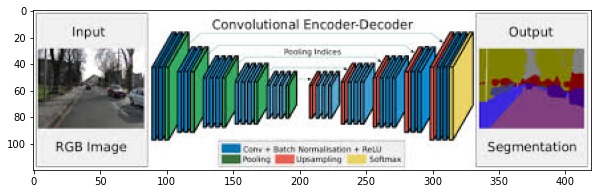

In [165]:
def load_img(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
image=load_img('../input/segnet1/segnet_model.jpeg')
fig, axs = plt.subplots(figsize=(15,40))
axs.imshow(image)

In [131]:
def segnet():
    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    

    
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    
    
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    output=Conv2D(13,(1,1),activation='softmax')(batch2)
    
    model=Model(input1,output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [132]:
segnet_model=segnet()

In [133]:
segnet_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 256, 256, 64) 256         conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_52[0][0]     
_______________________________________________________________________________________

# TRAINING SEGNET MODEL:

In [134]:
segnet_model.fit_generator(train_gen,steps_per_epoch=len(train_list) // 10,
        epochs=20,
        validation_data=valid_gen,
        validation_steps=len(test_list)//10)

Epoch 1/20
297/297 [==============================] - 166s 559ms/step - loss: 1.0148 - accuracy: 0.7148 - val_loss: 0.9860 - val_accuracy: 0.7317
Epoch 2/20
297/297 [==============================] - 164s 551ms/step - loss: 0.6967 - accuracy: 0.7993 - val_loss: 0.7498 - val_accuracy: 0.7866
Epoch 3/20
297/297 [==============================] - 164s 551ms/step - loss: 0.6168 - accuracy: 0.8199 - val_loss: 0.6859 - val_accuracy: 0.8042
Epoch 4/20
297/297 [==============================] - 165s 556ms/step - loss: 0.5661 - accuracy: 0.8327 - val_loss: 0.6455 - val_accuracy: 0.8138
Epoch 5/20
297/297 [==============================] - 164s 551ms/step - loss: 0.5294 - accuracy: 0.8424 - val_loss: 0.6193 - val_accuracy: 0.8244
Epoch 6/20
297/297 [==============================] - 163s 550ms/step - loss: 0.4970 - accuracy: 0.8505 - val_loss: 0.6140 - val_accuracy: 0.8270
Epoch 7/20
297/297 [==============================] - 164s 552ms/step - loss: 0.4739 - accuracy: 0.8567 - val_loss: 0.5953 -

## CONVERT PREDICTED CLASSES OUTPUT INTO IMAGE:

In [140]:
def classes_to_colors(pred):
    pred=np.array(pred).reshape((256,256,13))
    pred=np.argmax(pred,axis=2)

    mask=np.zeros((256,256,3))
    for i in range(13):
        ind=np.where(pred==i)
        mask[ind[0],ind[1],:]=kmeans.cluster_centers_[i]
    return mask
        

# SAVE AND LOAD MODEL

In [141]:
segnet_model.save('segnet_model.h5')

In [142]:
segnet_model=keras.models.load_model('./segnet_model.h5')

# PREDICTION:

In [153]:
print('select three images for prediction between 0 and '+str(len(test_list)))
img=[]
mask=[]
for i in range(3):
    k=input('select image number from test list:')
    im,m=load_image(test_list[int(k)])
    img.append(im)
    mask.append(m)
    

select three images for prediction between 0 and 500
select image number from test list:13
select image number from test list:67
select image number from test list:27


In [154]:
pred=[]
for i in range(3):
    p=segnet_model([img[i].reshape(1,256,256,3)])
    p=classes_to_colors(p)
    p=p.astype(int)
    pred.append(p)

# PLOTTING PREDICTED OUTPUTS USING SEGNET MODEL:

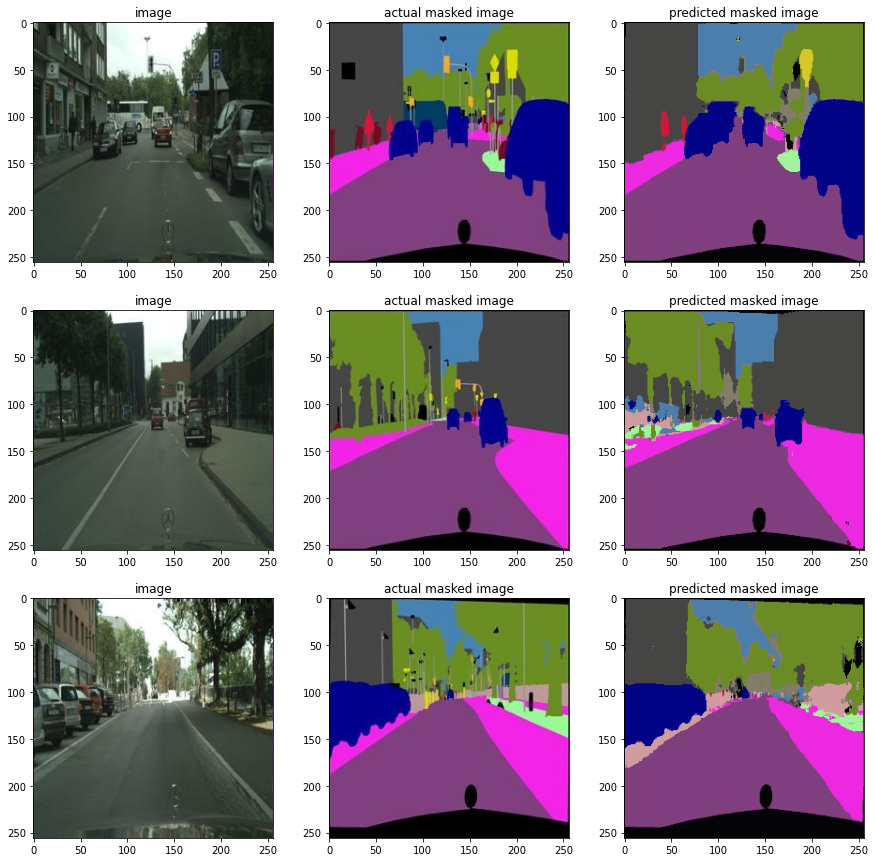

In [155]:
fig, axs = plt.subplots(3, 3,figsize=(15,15))

for i in range(3):
    axs[i][0].set_title('image')
    axs[i][0].imshow(img[i])
    axs[i][1].set_title('actual masked image')
    axs[i][1].imshow(mask[i])
    axs[i][2].set_title('predicted masked image')
    axs[i][2].imshow(pred[i])
plt.show()